In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from tools import BlindColours
from qqt_lambda_balanced import  QQT_lambda_balanced
from utils import get_random_regression_task, get_lambda_balanced
from linear_network import LinearNetwork

(array([[-0.85819472,  0.82768366, -0.59375045],
       [ 0.62468045,  0.538695  , -0.30957525],
       [ 0.23324445, -0.53604132, -0.80927402]]), array([[-0.97741788,  0.41762537,  0.18712597],
       [ 0.09405842,  0.0912589 ,  0.87093109],
       [-0.7830172 , -0.62986211,  0.07963185]]), array([[1.71068255, 0.        , 0.        ],
       [0.        , 0.92044698, 0.        ],
       [0.        , 0.        , 0.60468217]]), array([[ 1.96789383e-01,  4.02455846e-16,  5.27355937e-16],
       [ 4.02455846e-16,  1.96789383e-01, -1.11022302e-16],
       [ 5.27355937e-16, -1.11022302e-16,  1.96789383e-01]]))
print statement for debugging


In [2]:
blind_colours = BlindColours().get_colours()

In [3]:
def get_ntk(w1w1, w2w2, X, out_dim):
    return  np.kron(np.eye(out_dim), X.T @ w1w1 @ X) + np.kron(w2w2, X.T @ X)

In [4]:
in_dim = 3
hidden_dim = 3
out_dim = 3

batch_size = 10
learning_rate = 0.0002
training_steps = 50000


output_empirical = {}
output_analytical = {}

ws_empirical = {}
ws_analytical = {}

w1w1s_empirical = {}
w1w1s_analytical = {}

w2w2s_empirical = {}
w2w2s_analytical = {}

ntks_empirical = {}
ntks_analytical = {}

losses_list_empirical = {}
losses_list_analytical = {}




X, Y = get_random_regression_task(batch_size, in_dim, out_dim)


##Run model, keep track of w2, w1, log it into all of these lists
lmdas = [-50, 0.01, 50]

# lmdas= [0.01, 0.01]

for lmda in lmdas:
    
    # if lmda > 0:
    #     a = np.sqrt(lmda) + 1
    #     b = np.sqrt(2 * np.sqrt(lmda))
    # else:
    #     a = np.sqrt(2 * np.sqrt(np.abs(lmda)))
    #     b = np.sqrt(np.abs(lmda)) + 1

    # init_w1 = np.eye(hidden_dim) * a 
    # init_w2 = np.eye(hidden_dim) * b 

    init_w1, init_w2 = get_lambda_balanced(lmda, in_dim, hidden_dim, out_dim)
    # init_w1, init_w2, _, q = balanced_weights(in_dim, hidden_dim, out_dim)
    # while (np.sign(q[0][0]) != np.sign(lmda)):
    #     init_w1, init_w2, _, q = balanced_weights(in_dim, hidden_dim, out_dim)
    
    # factor = np.sqrt(lmda / q[0][0])

    # init_w1 = init_w1 * factor 
    # init_w2 = init_w2 * factor

    print(init_w2.T @ init_w2 - init_w1 @ init_w1.T)
    

    model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1.copy(), init_w2.copy())
    w1s, w2s, losses = model.train(X, Y, training_steps, learning_rate)

    ws_empirical[lmda] = [w2 @ w1 for (w2, w1) in zip(w2s, w1s)]
    ws_empirical[lmda] = np.expand_dims(ws_empirical[lmda], axis = 1)

    output_empirical[lmda] = [w @ X for w in ws_empirical[lmda]]
 
    w1w1s_empirical[lmda] = np.array([w1.T @ w1 for w1 in w1s])
    w2w2s_empirical[lmda] = np.array([w2 @ w2.T for w2 in w2s])

    losses_list_empirical[lmda] = [1/(2*batch_size) * np.linalg.norm(w @ X - Y)**2 for w in ws_empirical[lmda]]

    ntks_empirical[lmda] = np.array([get_ntk(w1w1, w2w2, X, out_dim) for (w1w1, w2w2) in zip(w1w1s_empirical[lmda], w2w2s_empirical[lmda])])


    analytical = QQT_lambda_balanced(init_w1.copy(), init_w2.copy(), X.T, Y.T, False)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])

    ws_analytical[lmda] = np.array([a[in_dim:, :out_dim] for a in analytical])
    output_analytical[lmda] = [w @ X for w in ws_analytical[lmda]]
    
    w1w1s_analytical[lmda] = np.array([a[:hidden_dim, :hidden_dim] for a in analytical])
    w2w2s_analytical[lmda] = np.array([a[hidden_dim:, hidden_dim:] for a in analytical])

    ntks_analytical[lmda] = np.array([get_ntk(w1w1, w2w2, X, out_dim) for (w1w1, w2w2) in zip(w1w1s_empirical[lmda], w2w2s_empirical[lmda])])

    losses_list_analytical[lmda] = [1/(2*batch_size) * np.linalg.norm(w @ X - Y, ord='fro')**2 for w in ws_analytical[lmda]]
    

##Run analytical, keep log all of the stuff into these lists


[[-5.00000000e+01  1.61502756e-14  2.24841847e-14]
 [ 1.61502756e-14 -5.00000000e+01  1.31838984e-15]
 [ 2.24841847e-14  1.31838984e-15 -5.00000000e+01]]
[[ 1.00000000e-02 -2.49800181e-16 -5.55111512e-16]
 [-2.49800181e-16  1.00000000e-02  2.22044605e-15]
 [-5.55111512e-16  2.22044605e-15  1.00000000e-02]]
[[5.00000000e+01 2.35575448e-15 1.97480921e-14]
 [2.35575448e-15 5.00000000e+01 1.75554016e-15]
 [1.97480921e-14 1.75554016e-15 5.00000000e+01]]


In [6]:
losses_list_analytical[0.01][-1]

0.892715093517362

In [7]:
losses_list_analytical[50][-1]

0.8825412694155457

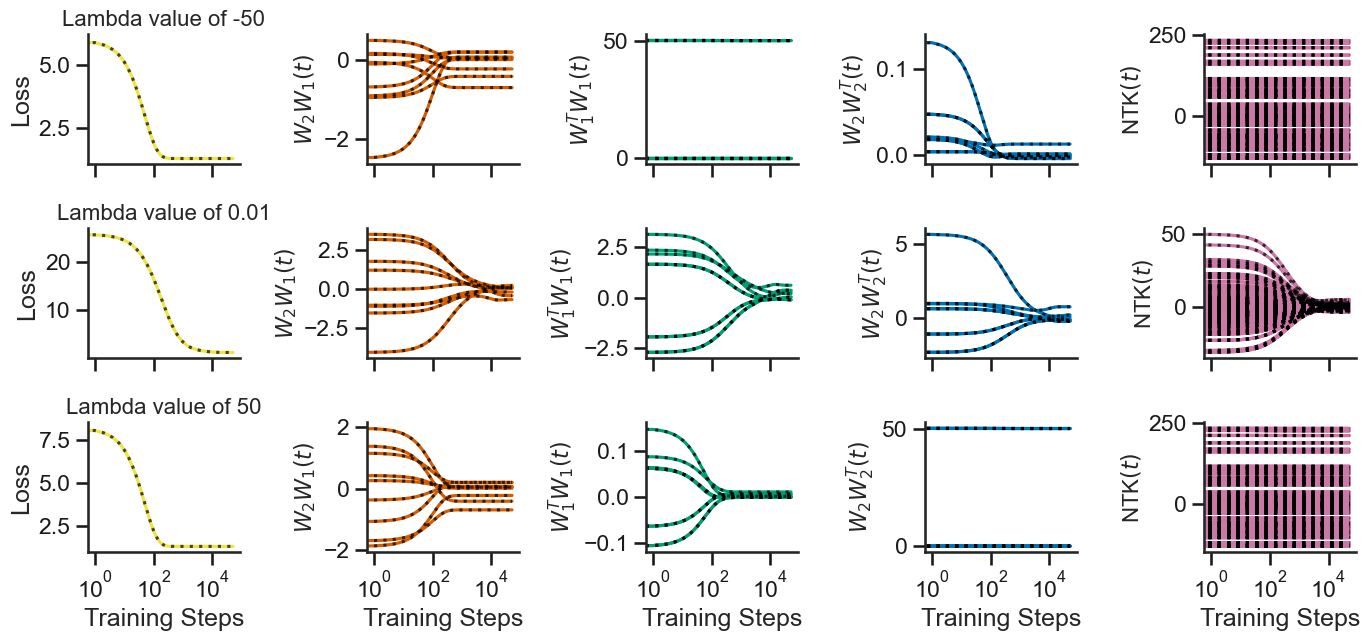

In [5]:
fig, axs_ = plt.subplots(len(lmdas), 5, figsize=(14, 4.5 * len(lmdas)/2), sharex=True)

for i, lmda in enumerate(lmdas):
    axs = axs_[i]
    
    axs[1].plot(ws_empirical[lmda].reshape(-1, in_dim * out_dim), color=blind_colours[0])
    # w2w1 = ws_analytical[lmda][:, in_dim:, :in_dim]
    axs[1].plot(ws_analytical[lmda].reshape(-1, in_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    #axs[1].set_ylim(-0.38, 0.3)
    #axs[1].set_yticks([ -0.2, 0., 0.2])
    axs[1].set_ylabel("$W_2W_1(t)$", fontsize=16)
    
    axs[0].plot(losses_list_empirical[lmda], color=blind_colours[6])
    loss = []
    # loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((w2w1 @ X.T - Y.T)**2, axis=2), axis=1)
    axs[0].plot(losses_list_analytical[lmda], c="k", alpha=0.7, linestyle=(0, (1, 2)))
    # axs[0].set_ylim(-0.075, 0.8)
    # axs[0].set_yticks([0., 0.25, 0.5, 0.75])
    axs[0].set_ylabel("Loss")
    
    
    axs[2].plot(w1w1s_empirical[lmda].reshape(-1, in_dim * in_dim), color=blind_colours[2])
    # w1w1 = analyticalss[mode][:, :in_dim, :in_dim]
    axs[2].plot(w1w1s_analytical[lmda].reshape(-1, in_dim * in_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    # axs[2].set_ylim(-0.3, 1.2)
    # axs[2].set_yticks([0., 0.5, 1.])
    axs[2].set_ylabel("$W_1^TW_1(t)$", fontsize=16)
    
    axs[3].plot(w2w2s_empirical[lmda].reshape(-1, out_dim * out_dim), color=blind_colours[1])
    # w2w2 = analyticalss[lmda][:, in_dim:, in_dim:]
    axs[3].plot(w2w2s_analytical[lmda].reshape(-1, out_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    # axs[3].set_ylim(-0.7, 1.1)
    # axs[3].set_yticks([-0.5, 0., 0.5, 1.])
    axs[3].set_ylabel("$W_2W_2^T(t)$", fontsize=16)
    
    axs[4].plot(ntks_empirical[lmda].reshape(-1, out_dim*batch_size * out_dim*batch_size), color=blind_colours[3])
    
    # ntk = np.kron(np.identity(out_dim), np.einsum("ab,cbd,de->cae", X, w1w1, X.T)) + np.kron(w2w2, X@X.T) #  + np.einsum("a,bc,cd->abd", np.trace(, axis1=1, axis2=2), X, X.T)
    axs[4].plot(ntks_analytical[lmda].reshape(-1, out_dim*batch_size * out_dim*batch_size), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[4].set_ylabel("NTK$(t)$", fontsize=16)
    # axs[4].set_ylim(-7, 8)
    # axs[4].set_yticks([-5, 0, 5])

    axs[0].set_title(f'Lambda value of {lmda}', fontsize=16)  

    if i == len(lmdas) - 1:
        for i in range(5):
            axs[i].set_xlabel("Training Steps")
    axs[0].set_xscale("log")
    axs[0].set_xticks([1., 100, 10000])
sns.despine()
# fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.tight_layout()
# fig.subplots_adjust(hspace=0.4)
# fig.savefig("./figures/figure-2_a-b.svg")